# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
#XVFB will be launched if you run on a server
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[2017-10-03 03:09:14,421] Making new env: CartPole-v0


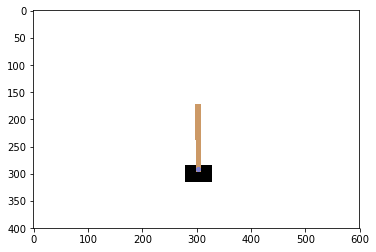

In [3]:
env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with theano/lasagne

First step is initializing input variables

In [4]:
import tensorflow as tf
import tensorflow.contrib.layers as tflayers  # Let's make TF simple again

In [5]:
#create input variables. We'll support multiple states at once
current_states = tf.placeholder(dtype=tf.float32,shape=(None,)+state_dim)
actions = tf.placeholder(tf.int32,shape=[None])
rewards = tf.placeholder(tf.float32,shape=[None])
next_states = tf.placeholder(tf.float32, shape=(None,)+state_dim)
is_end = tf.placeholder(tf.bool,shape=[None])

In [6]:
def network(l_states, scope=None, reuse=False):
    assert l_states.get_shape().as_list() == list((None,)+state_dim)
    with tf.variable_scope(scope or "network") as scope:
        if reuse:
            scope.reuse_variables()
        
        # <Your architecture. Please start with a single-layer network>

        return l_qvalues

#### Predicting Q-values for `current_states`

In [7]:
#get q-values for ALL actions in current_states
predicted_qvalues = network(current_states)

In [8]:
#select q-values for chosen actions
predicted_qvalues_for_actions = <...>

#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [9]:
predicted_next_qvalues = network(<...>, reuse=True)
gamma = 0.99
target_qvalues_for_actions = <target Q-values using rewards and predicted_next_qvalues>
target_qvalues_for_actions = tf.where(
    is_end, 
    tf.zeros_like(target_qvalues_for_actions),
    target_qvalues_for_actions)

In [10]:
#mean squared error loss function
loss = <mean squared between target_qvalues_for_actions and predicted_qvalues_for_actions>

In [11]:
#network updates. Note the small learning rate (for stability)
#Training function that resembles agent.update(state,action,reward,next_state) 
#with 1 more argument meaning is_end
train_step = tf.train.AdamOptimizer(1e-4).minimize(
    loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="network"))

### Playing the game

In [12]:
# Tensorflow feature - session
sess = tf.InteractiveSession()

In [13]:
# Tensorflow feature 2 - variables initializer
sess.run(tf.global_variables_initializer())

In [ ]:
# You can check all your valiables by:
# [v.name for v in tf.trainable_variables()]
# they should all starts with "network"

In [14]:
inial_epsilon = epsilon = 0.5
final_epsilon = 0.01
n_epochs = 1000

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    total_loss = 0
    
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = sess.run(
            predicted_qvalues, 
            feed_dict={current_states:np.array([s])})[0]
        
        a = <sample action with epsilon-greedy strategy>
        
        new_s,r,done,info = env.step(a)
        
        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        curr_loss, _ = sess.run(
            ..., 
            feed_dict={
                ...})

        total_reward += r
        total_loss += curr_loss
        
        s = new_s
        if done: break
            
    return total_reward, total_loss/float(t), t

In [15]:
from tqdm import trange
tr = trange(
    n_epochs,
    desc="mean reward = {:.3f}\tepsilon = {:.3f}\tloss = {:.3f}\tsteps = {:.3f}".format(0.0, 0.0, 0.0, 0.0),
    leave=True)


for i in tr:
    
    sessions = [generate_session() for _ in range(100)] #generate new sessions
    session_rewards, session_loss, session_steps = map(np.array, zip(*sessions))
    
    epsilon -= (inial_epsilon - final_epsilon) / float(n_epochs)
    
    tr.set_description("mean reward = {:.3f}\tepsilon = {:.3f}\tloss = {:.3f}\tsteps = {:.3f}".format(
        np.mean(session_rewards), epsilon, np.mean(session_loss), np.mean(session_steps)))

    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break
        
    assert epsilon!=0, "Please explore environment"

mean reward = 93.500	epsilon = 0.010	loss = 0.914	steps = 92.500: 100%|██████████| 1000/1000 [1:15:00<00:00,  7.59s/it] 


### Video

In [16]:
epsilon=0 #Don't forget to reset epsilon back to initial value if you want to go on training

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices